[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab9_transfer_learning.ipynb)

# Transfer Learning/Fine-Tuning

During training, neural networks often learn features that are useful for a wide variety of tasks. For example, the earliest layers of convolution networks often learn very basic visual features, such as edge detection. These task-agnostic features can be very useful when applied to other tasks. Transfer learning or fine-tuning is a technique that takes a network pretrained on one task and trains it on another. The idea is to tweak or tune the parameters on the new task, rather than making huge changes in learning. Fine-tuning is often quicker than learning on the new task from scratch, and can even lead to better overall performance and generalization.

Unfreezing a pretrained network is a fine-tuning technique that can be helpful when training a network on a difficult task with limited data.
If we allow the network to train its earliest layers immediately, then the earliest layers will forget all of the useful task-agnostic features they learned previously. So, rather than training all of the model weights at once, we learn on the last few layers (which are the most task-specific in the network). We can also gradually start training on the earlier layers as training progresses.

In this lab, you will compare unfreezing fine-tuning techniques against training a model from scratch. You will use the large ResNet-152 model to learn the small Bird Species Classification dataset.


### Grading

- 20% Analyze Dataset
- 20% Implementing `BirdNet`
- 20% Implementing `train()`
- 30% Running finetuning experiment
- 10% Answering questions


In [1]:
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda")

## Analyze `BirdDataset`

Start by first downloading the dataset from Kaggle.

#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab.

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 68 Nov 11 03:33 kaggle.json


3. Copy the desired dataset locally

In [4]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
!kaggle datasets download -d akash2907/bird-species-classification

Dataset URL: https://www.kaggle.com/datasets/akash2907/bird-species-classification
License(s): CC-BY-NC-SA-4.0
 99% 1.36G/1.37G [00:13<00:00, 230MB/s]
100% 1.37G/1.37G [00:13<00:00, 108MB/s]


The `BirdDataset` is implemented for you below. Instantiate a `train_dataset` and `val_dataset`.

In [5]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # We resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
                else:
                    print(f"else {name}")

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

In [6]:
train_dataset = BirdDataset(train=True)
val_dataset = BirdDataset(train=False)

Extracting bird-species-classification.zip
Resizing images


Print out the number of instances of each class in the `train_dataset` and `val_dataset`.

In [7]:
print("Train dataset:", len(train_dataset))
print("Val dataset:", len(val_dataset))

Train dataset: 150
Val dataset: 157


Print out a single image for each class in a 4x4 display.

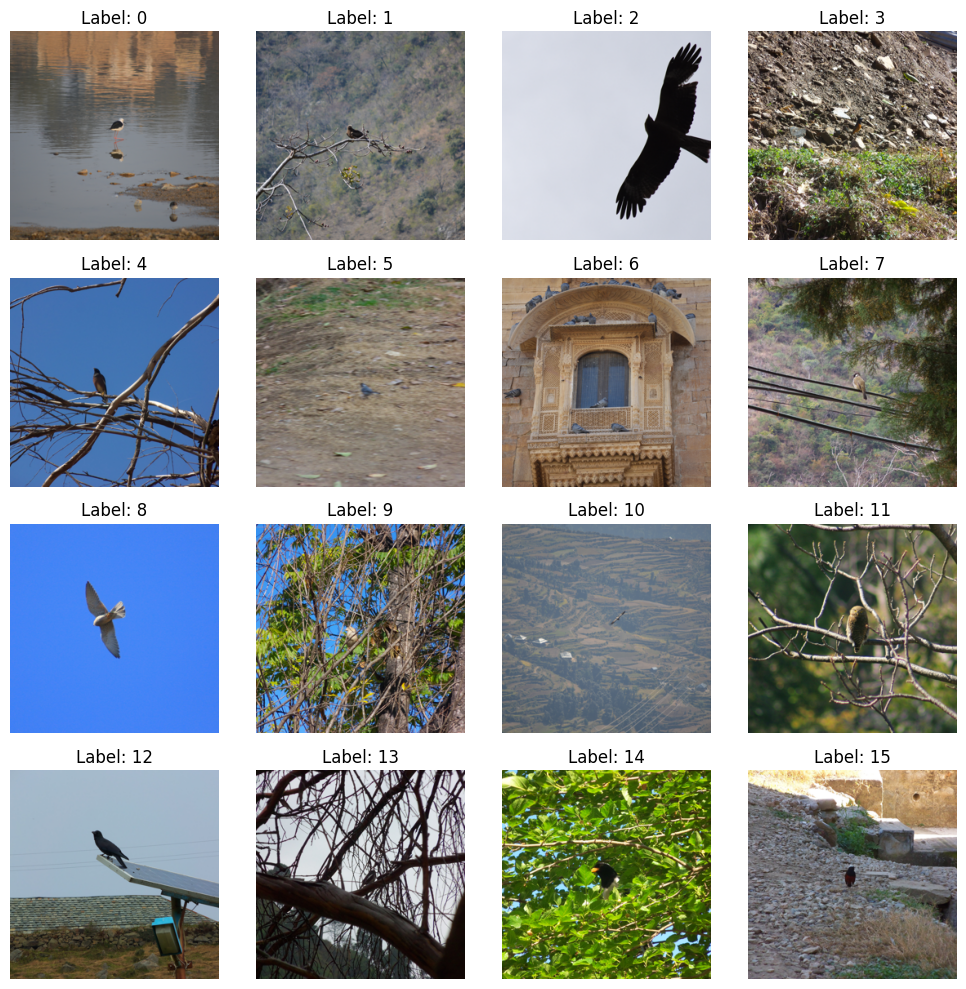

In [8]:
already_printed = set()    # Stores labels of classes that have already been printed
count = 1
plt.figure(figsize=(10, 10))
for datum in train_dataset:
    img, label = datum     # Extract data
    if label not in already_printed:
        already_printed.add(label)
        plt.subplot(4, 4, count)
        plt.imshow(img.permute(1, 2, 0))  # Print out image
        plt.title(f"Label: {label}")
        plt.axis('off')
        count += 1
plt.tight_layout()
plt.show()

You will notice that not only do we have a small training dataset (150 images), some of the images are potentially difficult to classify because of how small the bird appears in the image. If you investigated the images further you would notice that many images of a given class are subsequent snapshots of the same bird. This will make generalization hard and overfitting easy, especially with a large network.

## Implement `BirdNet`


Implement the `BirdNet`: a wrapper class adding functionality to a (pretrained) `ResNet`.

### Implement `__init__()`
- The `BirdNet` should first instantiate a `models.resnet152` object and optionally, load in pretrained weights (look at https://pytorch.org/vision/stable/models.html for more information about using pretrained weights). We suggest using `models.ResNet152_Weights.IMAGENET1K_V1`.
- Overwrite the final layer in the ResNet to linearly map (with `nn.Linear`) the previous layers features to `n_classes`.
- Freeze all weights except the final layer. You can do this with calling `.requires_grad = False` on the parameters or calling `.requires_grad(False)` on the layers.


### Implement `unfreeze()`
Implement `unfreeze()` to unfreeze the last `n_layers` of your model. Do not treat the sequential or bottleneck layers in the ResNet as a single layer; we consider a convolutional layer or linear layer as a single layer. You may optionally treat a batchnorm layer as its own layer or as part of a conv/linear layer. ReLU layers do not have parameters, so they can't be frozen/unfrozen.


**Tip**: *You can print out a `models.resnet152` object to get an idea of how many input features are used in the last layer as well as the structure and naming convention used by the ResNet to know how to unfreeze `n_layers`.*


Create a temporary resnet152 model and print it here to see the structure of the network and the naming conventions. You can iterate over `.named_parameters()` to get the name and parameter object, respectively, to verify the naming scheme. This function can make your unfreezing function simpler.

In [9]:
# Load in temporary model and print the names of the last few layers
temp_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
params = list(temp_model.named_parameters())
for param in params[-10:]:
    print(param[0])

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 109MB/s] 


layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [10]:
class BirdNet(nn.Module):
    def __init__(self, n_classes, pretrained_weights):
        super().__init__()
        if pretrained_weights is not None:  # Load in model w or w/o weights
          self.net = models.resnet152(weights=pretrained_weights)
        else:
          self.net = models.resnet152()
        self.params = list(self.net.named_parameters())  # Get the names of the parameters

        # Overwrite the final layer to linearly map the previous layers features to n_classes
        self.net.fc = nn.Linear(self.net.fc.in_features, n_classes)

        # Freeze all layers except the last two (which are the final layer)
        for name, param in self.params[:-2]:
            param.requires_grad = False

    def unfreeze(self, n_layers):
        # Unfreeze the last n layers

        # Initialize a counter for how many layers we've unfrozen
        unfrozen_layers = 0

        # Traverse the model layers in reverse order
        for name, param in reversed(self.params):
          if "bias" in name:  # Biases don't add to total count of layers since there also is a corresponding weight matrix
            param.requires_grad = True
          elif "weight" in name:
            param.requires_grad = True
            unfrozen_layers += 1
          if unfrozen_layers >= n_layers:  # Stop at certain amount of layers
            break

    def forward(self, x):
        return self.net(x)

## Training

In [11]:
@torch.no_grad()
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()


@torch.no_grad()
def evaluate(model, loss_fn, val_loader):
    val_losses = 0
    val_accs = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()

    for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses += loss_fn(y_hat, y_truth).item() * len(x)
        val_accs += accuracy(y_hat, y_truth) * len(x)

    model.train()
    return val_losses/len(val_dataset), val_accs/len(val_dataset)


Implement the `train()` function. Keep track of the usual performance metrics (training/validation losses and accuracies) and additionally keep track of how long, in seconds, training took (this is referred to as wallclock training time).

There are two additional arguments in `train()`: `slowly_unfreeze` and `unfreeze_interval`.
 If `slowly_unfreeze=True` then for every `unfreeze_interval` number of steps you should unfreeze an additional layer from your model.

In [16]:
def train(model, optimizer, train_loader, val_loader, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    wall_clock_training_time = []

    for i in range(1, n_optimization_steps+1):

        start = time.time()

        if slowly_unfreeze and i % unfreeze_interval == 0:  # Unfreeze later layers if desired
          model.unfreeze(i // unfreeze_interval + 1)

        x, y = next(iter(train_loader))   # Load in data
        x, y = x.to(device), y.to(device)
        y_hat = model(x)   # Get predicted output
        loss = loss_fn(y_hat.view(-1, y_hat.shape[-1]), y.view(-1))   # Calculate loss
        loss.backward()    # Gradient descent stuff
        optimizer.step()
        optimizer.zero_grad()

        end = time.time()

        wall_clock_training_time.append(end - start)
        acc = accuracy(y_hat, y)   # Calculate accuracy
        train_losses.append(loss.item())
        train_accs.append(acc)

        # Validation loss and accuracy
        if i % log_interval == 0 or i == 1:
          eval_loss, eval_acc = evaluate(model, loss_fn, val_loader)
          val_losses.append(eval_loss)
          val_accs.append(eval_acc)
          print(f"Training Step {i} --> Train_Loss: {loss.item()}, Train_acc {acc}, Val_Loss: {eval_loss}, Val_acc: {eval_acc}")

    return train_losses, train_accs, val_losses, val_accs, wall_clock_training_time

To compare how well finetuning works you will perform a set of experiments. There are four models you will train for `n_trials >= 3`:
- `res-reinit`: A reinitialized (not pretrained) resnet model. This is the baseline.
- `res1`: A pretrained resnet model with only the last layer unfrozen.
- `res3`: A pretrained resnet model with the last 3 layers unfrozen.
- `res10-slow`: A pretrained resnet model with the last last 10 layers **slowly** unfrozen.

For each model average the results across the `n_trials` and plot the val accuracy across time for each model and print out the average wallclock time and time per optimization step (i.e. wallclock_time / optimization_step) . **Do not forget to recreate the model and optimizer between each trial.**


**Tip:** Make sure everything is implemented correctly before running all `n_trials` on all four models. We found that a learning rate of .001 worked well for 100 optimization steps.

In [17]:
# Initial variables
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
n_optimization_steps = 100
log_interval = 10
lr = 0.001
n_trials = 3
indices = list(range(-1, n_optimization_steps+1, log_interval))
indices[0] = 0
# models.ResNet152_Weights.IMAGENET1K_V1

In [18]:
def test(name, pretrained_weights, numfrozen, slowly_unfreeze, unfreeze_interval):
  print(f"==================================={name}===================================")
  all_train_losses, all_train_accs, all_val_losses, all_val_accs = [], [], [], []
  all_wall_clock_training_times = []
  for i in range(n_trials):  # For each trial
    # Get the model
    model = BirdNet(n_classes=len(train_dataset.dataset_folder.classes), pretrained_weights=pretrained_weights)
    model.to(device)
    # Unfreeze last few layers
    if numfrozen is not None: model.unfreeze(numfrozen)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Train it
    train_losses, train_accs, val_losses, val_accs, wall_clock_training_time = train(model, optimizer, train_loader, val_loader, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval)
    # Record statistics
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)
    all_wall_clock_training_times.append(np.cumsum(wall_clock_training_time))
    print()

  # Avergage the results
  print()
  avg_train_losses, avg_train_accs = np.mean(all_train_losses, axis=0), np.mean(all_train_accs, axis=0)
  avg_val_losses, avg_val_accs = np.mean(all_val_losses, axis=0), np.mean(all_val_accs, axis=0)
  avg_wall_clock_training_times = np.mean(all_wall_clock_training_times, axis=0)
  total_times = np.sum(all_wall_clock_training_times, axis=0)

  # Plot and print info
  training_times = [avg_wall_clock_training_times[i] for i in indices]
  plt.plot(training_times, avg_val_accs)
  plt.title(f"Validation Accuracy: {name}")
  plt.xlabel("Time (s)")
  plt.ylabel("Accuracy")
  plt.show()
  print("Average Wall Clock Time:", np.mean(total_times))
  print("Average Time Per Optimization Step:", np.mean(total_times) / n_optimization_steps)

===================================res-reinit===================================
Training Step 1 --> Train_Loss: 2.746567964553833, Train_acc 0.0, Val_Loss: 2.7793740694689903, Val_acc: 0.12101910960902075
Training Step 10 --> Train_Loss: 3.1393556594848633, Train_acc 0.125, Val_Loss: 2.82117795184919, Val_acc: 0.057324841238890485
Training Step 20 --> Train_Loss: 2.4626007080078125, Train_acc 0.125, Val_Loss: 3.120117626372416, Val_acc: 0.12738853526912677
Training Step 30 --> Train_Loss: 2.472034454345703, Train_acc 0.0625, Val_Loss: 3.294165588488245, Val_acc: 0.06369426751592357
Training Step 40 --> Train_Loss: 2.6342151165008545, Train_acc 0.25, Val_Loss: 3.117361714126198, Val_acc: 0.09554140127388536
Training Step 50 --> Train_Loss: 2.917576789855957, Train_acc 0.25, Val_Loss: 2.9303939965120547, Val_acc: 0.12101910851753442
Training Step 60 --> Train_Loss: 2.7812347412109375, Train_acc 0.125, Val_Loss: 3.3306277891632856, Val_acc: 0.09554140151116498
Training Step 70 --> Train_

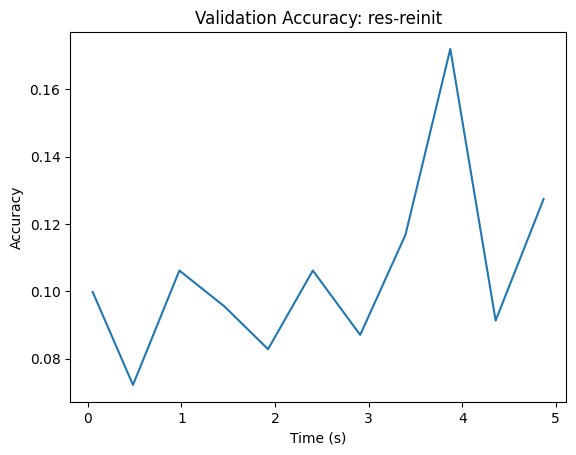

Average Wall Clock Time: 7.346058127880096
Average Time Per Optimization Step: 0.07346058127880097


===================================res1===================================
Training Step 1 --> Train_Loss: 2.701982021331787, Train_acc 0.0625, Val_Loss: 2.9682663307068453, Val_acc: 0.07006369426751592
Training Step 10 --> Train_Loss: 2.4582085609436035, Train_acc 0.25, Val_Loss: 2.698744117834006, Val_acc: 0.22929936305732485
Training Step 20 --> Train_Loss: 2.0313713550567627, Train_acc 0.4375, Val_Loss: 2.2822625409265993, Val_acc: 0.2547770706331654
Training Step 30 --> Train_Loss: 1.579061508178711, Train_acc 0.5625, Val_Loss: 2.0312403151943426, Val_acc: 0.4394904477581097
Training Step 40 --> Train_Loss: 0.9646809101104736, Train_acc 0.75, Val_Loss: 1.9030936926033846, Val_acc: 0.4203821671236852
Training Step 50 --> Train_Loss: 0.7240686416625977, Train_acc 0.8125, Val_Loss: 1.7908388877370556, Val_acc: 0.5031847160333281
Training Step 60 --> Train_Loss: 0.5540475249290466, Tra

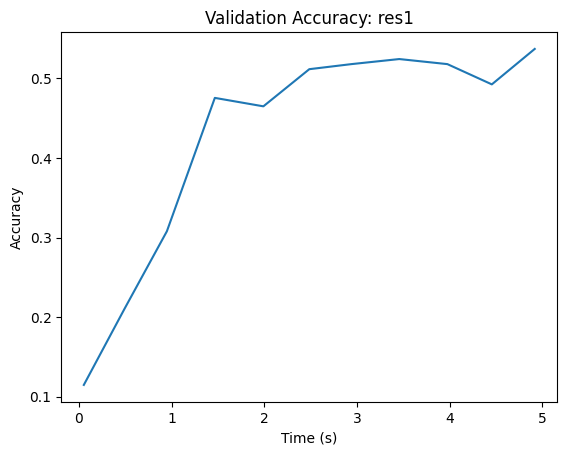

Average Wall Clock Time: 7.469275696277618
Average Time Per Optimization Step: 0.07469275696277618


===================================res3===================================
Training Step 1 --> Train_Loss: 2.8324782848358154, Train_acc 0.125, Val_Loss: 2.833851657855283, Val_acc: 0.057324841001610845
Training Step 10 --> Train_Loss: 1.0780757665634155, Train_acc 0.75, Val_Loss: 2.452304815790456, Val_acc: 0.2929936310478077
Training Step 20 --> Train_Loss: 0.5867714285850525, Train_acc 0.9375, Val_Loss: 1.7975096793691063, Val_acc: 0.5031847160333281
Training Step 30 --> Train_Loss: 0.4139956533908844, Train_acc 0.875, Val_Loss: 1.7810533016350618, Val_acc: 0.46496815552377396
Training Step 40 --> Train_Loss: 0.43559372425079346, Train_acc 0.875, Val_Loss: 1.6911942229908743, Val_acc: 0.5095541427849205
Training Step 50 --> Train_Loss: 0.16453434526920319, Train_acc 1.0, Val_Loss: 1.7991424411725088, Val_acc: 0.4904458625301434
Training Step 60 --> Train_Loss: 0.09750926494598389, Tr

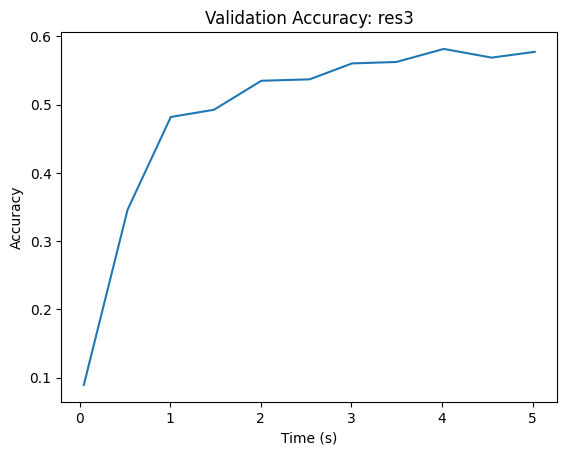

Average Wall Clock Time: 7.623621292114258
Average Time Per Optimization Step: 0.07623621292114258


===================================res10-slow===================================
Training Step 1 --> Train_Loss: 2.731682777404785, Train_acc 0.1875, Val_Loss: 2.9870994987001844, Val_acc: 0.057324841001610845
Training Step 10 --> Train_Loss: 2.084559440612793, Train_acc 0.375, Val_Loss: 2.563443205159181, Val_acc: 0.2866242042962153
Training Step 20 --> Train_Loss: 1.6698682308197021, Train_acc 0.5, Val_Loss: 2.210423399688332, Val_acc: 0.2929936319020144
Training Step 30 --> Train_Loss: 0.6599320769309998, Train_acc 0.8125, Val_Loss: 1.7788660754064085, Val_acc: 0.4713375809466004
Training Step 40 --> Train_Loss: 0.5115480422973633, Train_acc 0.875, Val_Loss: 1.6979082147027278, Val_acc: 0.5350318477032291
Training Step 50 --> Train_Loss: 0.09452207386493683, Train_acc 1.0, Val_Loss: 2.105473795514198, Val_acc: 0.5414012761632349
Training Step 60 --> Train_Loss: 0.12823763489723206, T

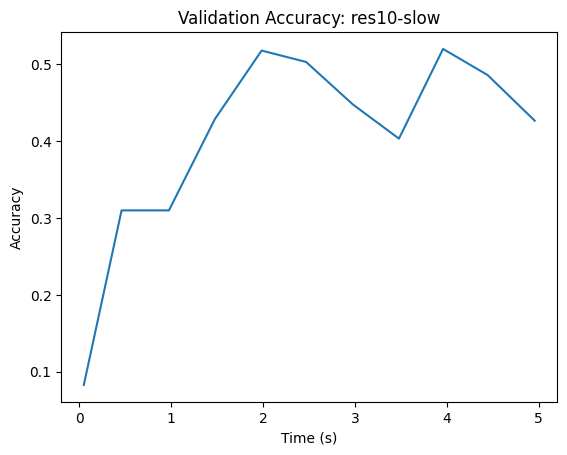

Average Wall Clock Time: 7.481871333122253
Average Time Per Optimization Step: 0.07481871333122253


In [19]:
# Initial variables
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
n_optimization_steps = 100
log_interval = 10
lr = 0.001
n_trials = 3
indices = list(range(-1, n_optimization_steps+1, log_interval))
indices[0] = 0
# models.ResNet152_Weights.IMAGENET1K_V1

test("res-reinit", None, None, False, None)
print()
print()
test("res1", models.ResNet152_Weights.IMAGENET1K_V1, None, False, None)
print()
print()
test("res3", models.ResNet152_Weights.IMAGENET1K_V1, 3, False, None)
print()
print()
test("res10-slow", models.ResNet152_Weights.IMAGENET1K_V1, None, True, 10)

### Questions
- Which model performed the best?
- How do the finetuned models compare to the reinitialized model in terms of time?
- Why are the ImageNet weights helpful to learning the Bird dataset?
- Why do we only unfreeze the last few layers?
- What are some pros and cons of pretraining?


The model that was reinitialized was by far the worst. Its leaning was very noisy and the validation accuracy never got any better than 18\%. This makes since becuase it is a very deep model that started from scratch. So, we robably need a lot more training steps to make any significant progress.

The res1 model was much better. This is because it used pretrained weights from a Resnet that already works well for image classification. So, the model already had the ability to learn features from images. Since the pre-training was done with a much larger dataset (ImageNet) than the Bird dataset, it generalizes well, despite the fact that our dataset was small. Overall, learning was much easier and more effective. However, since we only updated the last layer, the accuracy capped off at around 55\%.

The res3 model performed similar to res1, but even better. This makes sense because it used a pretrained model to start well and fine tuned the last 3 layers (instead of just the last one). So, this gave the model more fleibility to learn higher-order features.

The last model did not perform as well as I expected. This model was different than the last few by training on more layers at every 10 optimization steps. At first, it learned really well. But, eventually, after learning on more layers at the end, the validation accuracy actually decreased. I think that this is because the size of our dataset is small. The model was learning random features to give it a high training accuracy. But, it was loosing the good qualities of the pre-trained model (making it not generalize well). So, it makes sense to only unfreeze the last few layers. We do not want to overfit.

To my surprise, there was no significant difference in the training time, per step, in each model. This must be because of how the GPU resources were allocated and because of how small the dataset was. However, in order to get the same level of accuracy, the model that was not pretrained will likely require much more time to trian. I also assume that the models that learn more layers are a bit slower (because they have more parameters to update).

Overall, pre-training seems to greatly improve resuls. It makes training much faster and improves accuracy. It also helps make the problem solveble even if we have limited data. However, it is not perfect since pre-training is often based on fundamentally different datasets. And, it does require on already existing model to be feasible at all.